In [129]:
# PCA Visualization

In [130]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn import metrics
from itertools import combinations
import itertools
import json
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import matplotlib

In [131]:
# Key Features: op_num_people, of_pose_distance, of_gaze_distance, of_confidence, ros_mistakes_session, ros_ts_robot_talked, timestamp
use_key_features = True

only_of_success = True

# 1 -- Load Data

In [132]:
# Windowed Data: 1 Second Overlapping Windows, Feature Median + Variance in Window 
p5_file = '../../../../Google Drive File Stream/My Drive/USC Expeditions Year 5/Analysis/Engagement/Data/Master Window/p5_master_window.csv'
p7_file = '../../../../Google Drive File Stream/My Drive/USC Expeditions Year 5/Analysis/Engagement/Data/Master Window/p7_master_window.csv'
p9_file = '../../../../Google Drive File Stream/My Drive/USC Expeditions Year 5/Analysis/Engagement/Data/Master Window/p9_master_window.csv'
p11_file = '../../../../Google Drive File Stream/My Drive/USC Expeditions Year 5/Analysis/Engagement/Data/Master Window/p11_master_window.csv'
p12_file = '../../../../Google Drive File Stream/My Drive/USC Expeditions Year 5/Analysis/Engagement/Data/Master Window/p12_master_window.csv'
p17_file = '../../../../Google Drive File Stream/My Drive/USC Expeditions Year 5/Analysis/Engagement/Data/Master Window/p17_master_window.csv'
p18_file = '../../../../Google Drive File Stream/My Drive/USC Expeditions Year 5/Analysis/Engagement/Data/Master Window/p18_master_window.csv'

data5 = pd.read_csv(p5_file)
data7 = pd.read_csv(p7_file)
data9 = pd.read_csv(p9_file)
data11 = pd.read_csv(p11_file)
data12 = pd.read_csv(p12_file)
data17 = pd.read_csv(p17_file)
data18 = pd.read_csv(p18_file)

In [133]:
data = [data5, data7, data9, data11, data12, data17, data18]
part = [5, 7, 9, 11, 12, 17, 18]

In [134]:
remove = [
'engagement_change',
'ros_GAME_STATE',
'ros_PARTICIPANT_STATE',
'ros_ROBOT_STATE',
'ros_activity',
'ros_diff_1_change',
'ros_diff_2_change',
'ros_diff_3_change',
'ros_diff_4_change',
'ros_diff_5_change',
'ros_difficulty',
'ros_skill_EM_change',
'ros_skill_NC_change',
'ros_skill_OS_change',
'ros_ts_attempt_var',
'ros_games_session_change',
'ros_in_game_change',
'ros_mistakes_session_change',
'ros_mistakes_game_change',
'ros_skill',
'ros_ts_game_start_var',
'ros_ts_robot_talked_var',
'ros_game_correct',
'ros_game_incorrect',
'ros_game_start',
'ros_mistake_made',
]

for i, d in enumerate(data):
    data[i] = d.drop(columns=remove)

In [135]:
# Remove rows where engagment NaN
for i,d in enumerate(data):
    data[i] = d[np.isfinite(d['engagement'])]
    
# Remove rows where engagment is -1
for i,d in enumerate(data):
    data[i] = d[d['engagement']>=0]

# 2 -- Choose Feature Set

Feature Dictionary: https://docs.google.com/spreadsheets/d/1ewoVPHwW68Ins0AOVZf-0lsl_wW0_ZzuByuDiNJETBY/edit?usp=sharing

### Data Overview

In [136]:
# Main Columns
basic_cols = []
for i in data[0].columns:
    if 'of_' not in i and 'op_' not in i and 'ros_' not in i and 'a_' not in i:
        basic_cols.append(i)
        
basic_cols = sorted(basic_cols)
for i in basic_cols:
    print(i)

engagement
participant
session_num
timestamp


In [137]:
# Open Face Columns

of_cols = []
for i in data[0].columns:
    if ('of_' in i or 'op_' in i) and '_change' not in i and '_var' not in i:
        of_cols.append(i)
        
of_cols = sorted(of_cols)
for i in of_cols:
    print(i)

of_AU01_c
of_AU02_c
of_AU04_c
of_AU05_c
of_AU06_c
of_AU07_c
of_AU09_c
of_AU10_c
of_AU12_c
of_AU14_c
of_AU15_c
of_AU17_c
of_AU20_c
of_AU23_c
of_AU25_c
of_AU26_c
of_AU28_c
of_AU45_c
of_confidence
of_gaze_0_x
of_gaze_0_y
of_gaze_0_z
of_gaze_1_x
of_gaze_1_y
of_gaze_1_z
of_gaze_angle_x
of_gaze_angle_y
of_gaze_distance
of_gaze_distance_x
of_gaze_distance_y
of_pose_Rx
of_pose_Ry
of_pose_Rz
of_pose_Tx
of_pose_Ty
of_pose_Tz
of_pose_distance
of_success
of_ts_success
op_num_people


In [138]:
# Audio Columns

a_cols = []
for i in data[0].columns:
    if 'a_' in i and '_change' not in i and '_var' not in i:
        a_cols.append(i)
        
a_cols = sorted(a_cols)
for i in a_cols:
    print(i)

a_harmonicity
a_intensity
a_mfcc_0
a_mfcc_1
a_pitch_frequency
a_pitch_strength


In [139]:
# ROS Columns

ros_cols = []
for i in data[0].columns:
    if 'ros_' in i and '_change' not in i and '_var' not in i:
        ros_cols.append(i)
        
ros_cols = sorted(ros_cols)
for i in ros_cols:
    print(i)

ros_aptitude
ros_diff_1
ros_diff_2
ros_diff_3
ros_diff_4
ros_diff_5
ros_games_session
ros_in_game
ros_mistakes_game
ros_mistakes_session
ros_skill_EM
ros_skill_NC
ros_skill_OS
ros_ts_attempt
ros_ts_game_start
ros_ts_robot_talked


In [140]:
# For Window Only:
non_window_features = []
window_features = []
for i in data[0].columns:
    if i not in basic_cols:
        if 'change' in i or 'var' in i:
            window_features.append(i)
        else:
            non_window_features.append(i)
        
window_features = sorted(window_features)
for i in window_features:
    print(i)

a_harmonicity_var
a_intensity_var
a_mfcc_0_var
a_mfcc_1_var
a_pitch_frequency_var
a_pitch_strength_var
of_AU01_c_change
of_AU02_c_change
of_AU04_c_change
of_AU05_c_change
of_AU06_c_change
of_AU07_c_change
of_AU09_c_change
of_AU10_c_change
of_AU12_c_change
of_AU14_c_change
of_AU15_c_change
of_AU17_c_change
of_AU20_c_change
of_AU23_c_change
of_AU25_c_change
of_AU26_c_change
of_AU28_c_change
of_AU45_c_change
of_confidence_var
of_gaze_0_x_var
of_gaze_0_y_var
of_gaze_0_z_var
of_gaze_1_x_var
of_gaze_1_y_var
of_gaze_1_z_var
of_gaze_angle_x_var
of_gaze_angle_y_var
of_gaze_distance_var
of_gaze_distance_x_var
of_gaze_distance_y_var
of_pose_Rx_var
of_pose_Ry_var
of_pose_Rz_var
of_pose_Tx_var
of_pose_Ty_var
of_pose_Tz_var
of_pose_distance_var
of_success_change
of_ts_success_var
op_num_people_change
ros_aptitude_var


In [141]:
# Columns where NaNs filled with max value
nan_max_cols = ['of_gaze_0_x',
'of_gaze_0_y',
'of_gaze_0_z',
'of_gaze_1_x',
'of_gaze_1_y',
'of_gaze_1_z',
'of_gaze_angle_x',
'of_gaze_angle_y',
'of_gaze_distance',
'of_gaze_distance_x',
'of_gaze_distance_y',
'of_pose_Rxv',
'of_pose_Ry',
'of_pose_Rz',
'of_pose_Tx',
'of_pose_Ty',
'of_pose_Tz',
'of_pose_distance']

In [142]:
# Key Features (from feature analysis) 
# Note: Timestamp automatically included

key_features = [
'op_num_people',
'of_pose_distance',
'of_gaze_distance',
'of_confidence',
'ros_mistakes_session',
'ros_ts_robot_talked']

### Filter Feature Set (Optional)

In [143]:
if only_of_success:
    for i,d in enumerate(data):
        data[i] = d[d['of_success']==1]

In [144]:
# always include basic_cols, add desired group of features 
# features_to_keep = all_data.columns

if use_key_features:
    features_to_keep = basic_cols + key_features
else:
    features_to_keep = basic_cols + of_cols + ros_cols + a_cols + window_features

for i,d in enumerate(data):
    data[i] = d[features_to_keep]

# 3 -- Preprocessing

In [145]:
data_all = pd.concat(data, ignore_index=True, sort=True)

In [146]:
for c in data_all.columns:
    if c in ['engagement', 'participant', 'session_num']:
        continue
    mean = np.nanmean(data_all[c])
    std = np.nanstd(data_all[c])
    
    if (sum(pd.isna(data_all[c])) == len(data_all)):
        data_all[c] = 0
        continue
    
    if std == 0:
        data_all[c] = (data_all[c]-mean)
    else:
        data_all[c] = (data_all[c]-mean)/(std)

    if c not in nan_max_cols:
        min_val = np.nanmin(data_all[c])
        data_all[c] = data_all[c].fillna(min_val)
    else:
        max_val = np.nanmax(data_all[c])
        data_all[c] = data_all[c].fillna(max_val) 

# 4 -- PCA

In [147]:
from sklearn.decomposition import PCA

to_compress = data_all.drop(columns=['engagement', 'participant', 'session_num', 'timestamp', 'of_confidence'])

pca = PCA(n_components=2)
compress = pca.fit_transform(to_compress)

print('pca variance', pca.explained_variance_ratio_)  

data_all['pca1'] = [i[0] for i in compress]
data_all['pca2'] = [i[1] for i in compress]

pca variance [0.43583272 0.20388605]


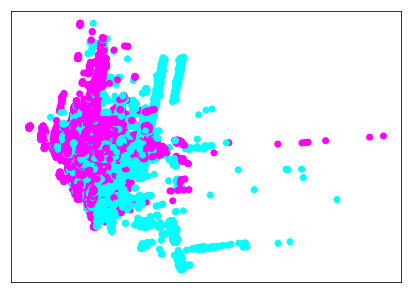

In [148]:
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams["figure.figsize"] = [7,5]
fig = plt.figure()


plt.scatter(data_all['pca1'], data_all['pca2'], c=data_all['engagement'], cmap='cool')

axes = plt.gca()
#axes.set_xlim([-5,10])
#axes.set_ylim([-6,6])

plt.xticks([])
plt.yticks([])

plt.show()

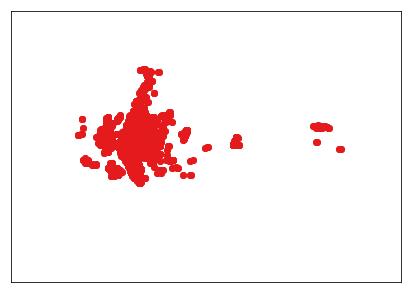

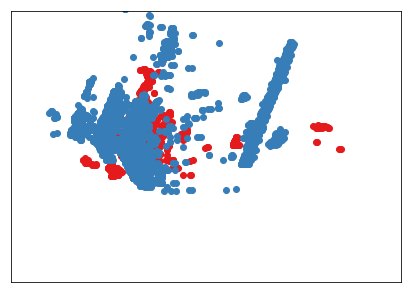

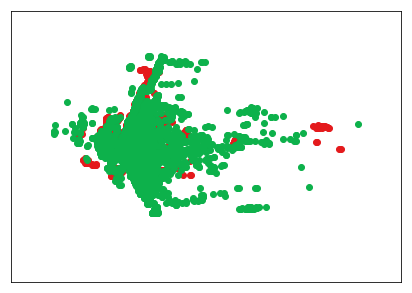

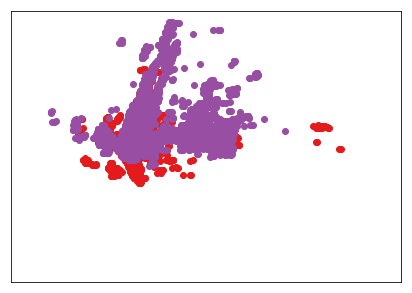

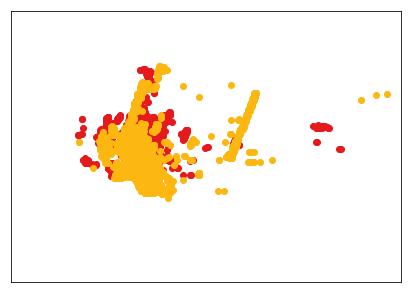

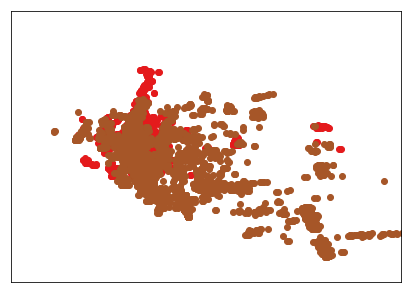

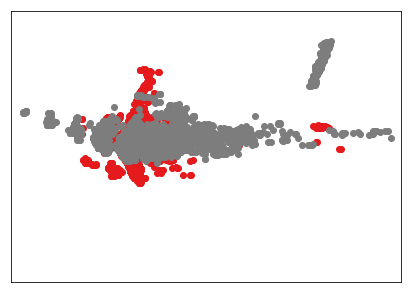

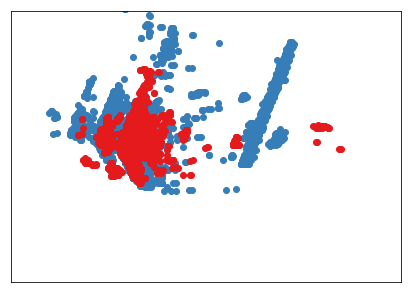

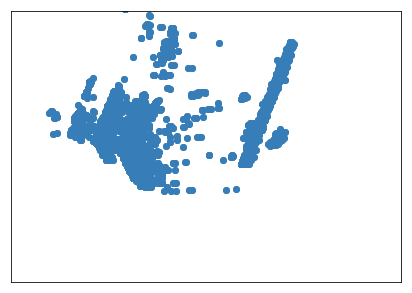

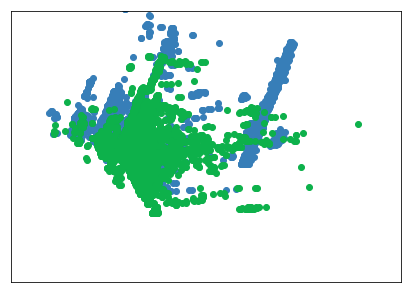

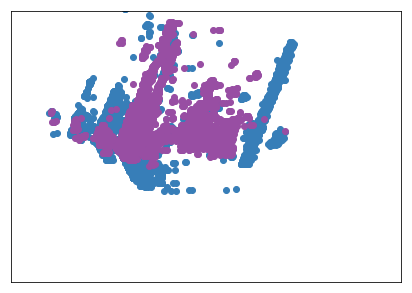

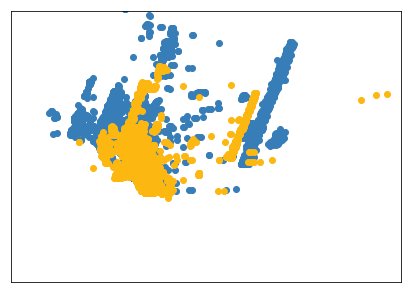

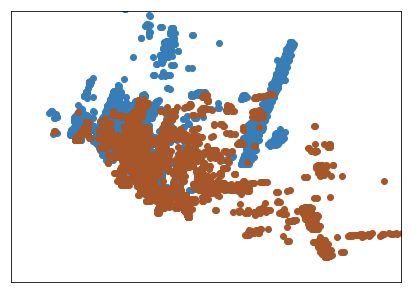

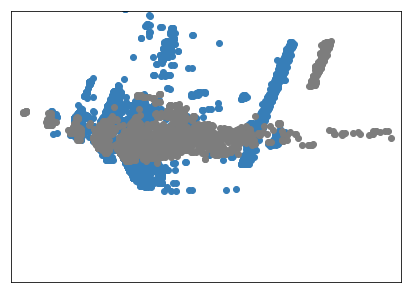

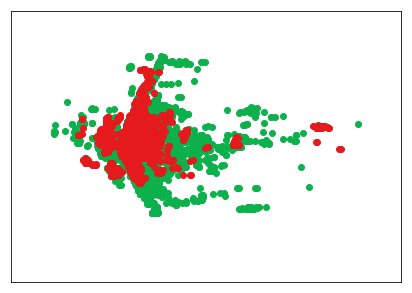

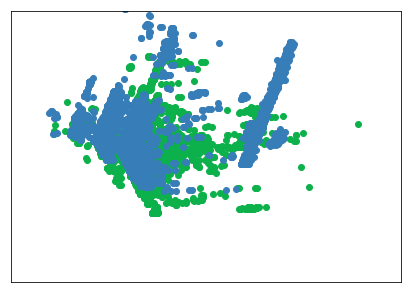

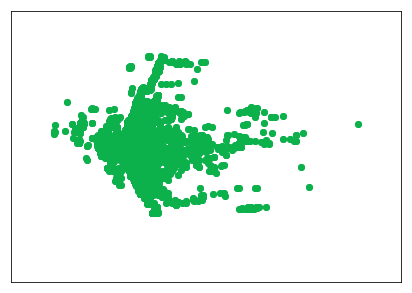

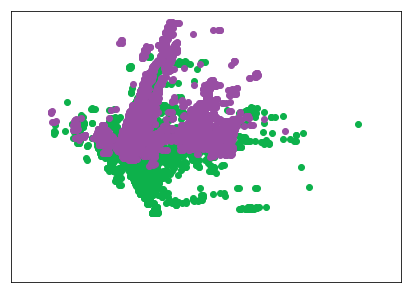

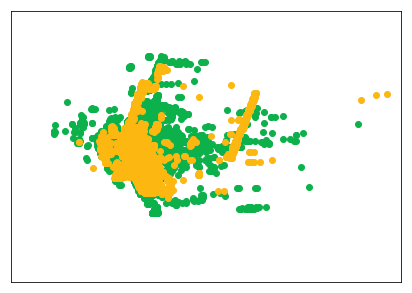

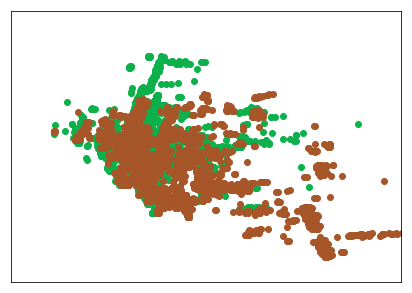

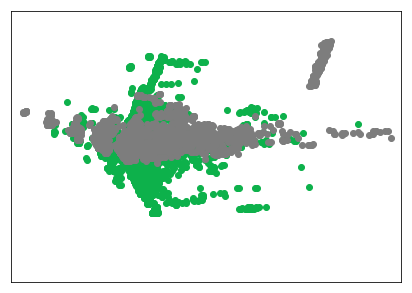

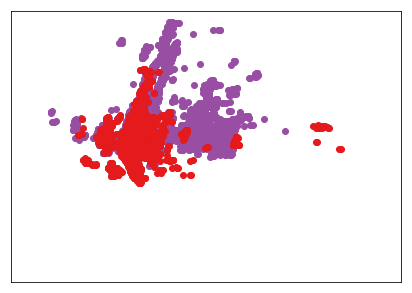

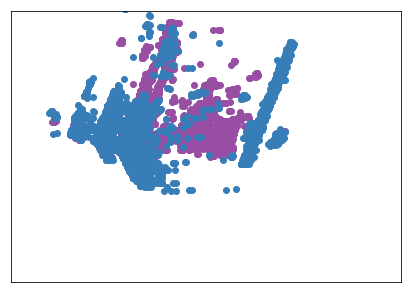

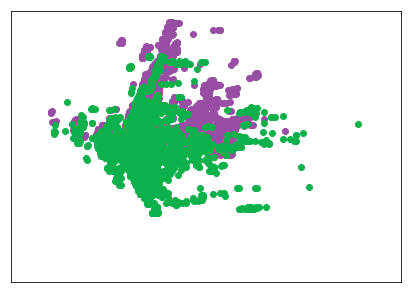

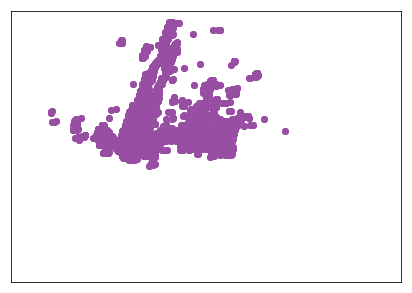

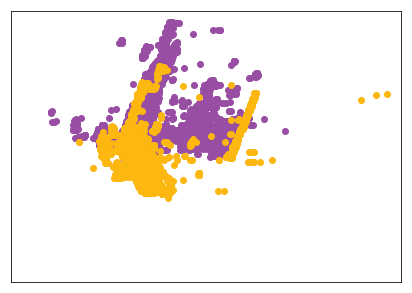

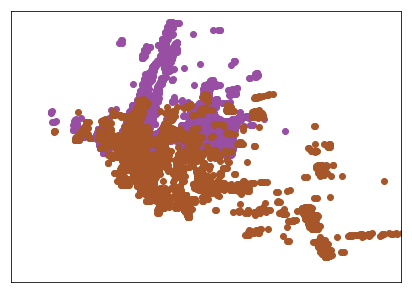

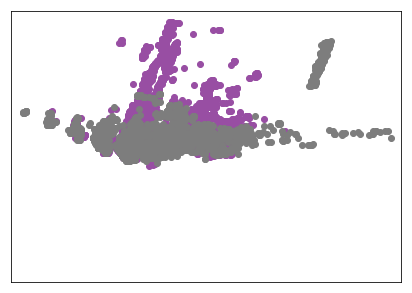

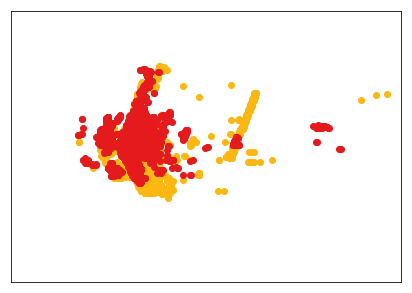

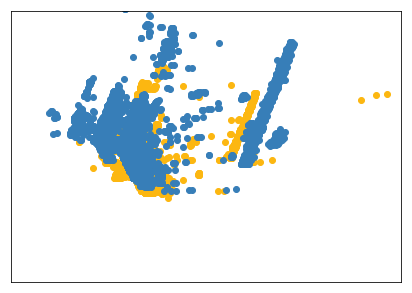

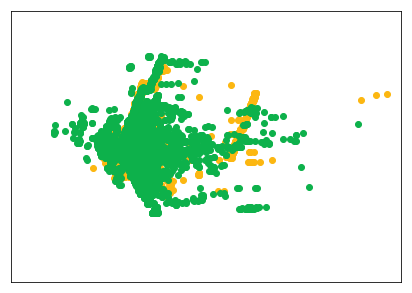

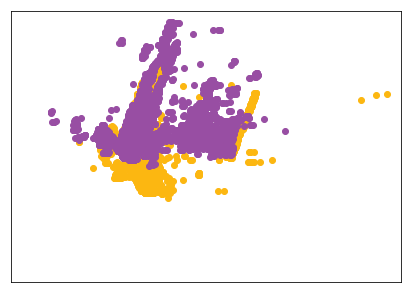

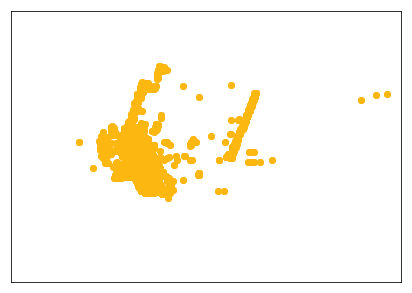

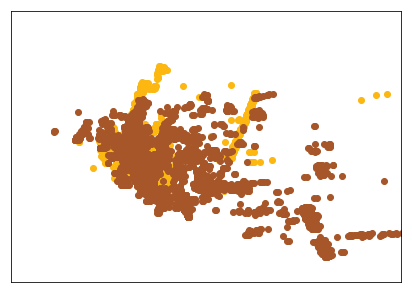

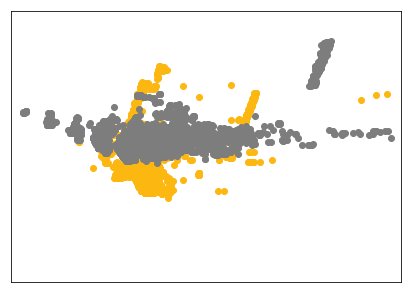

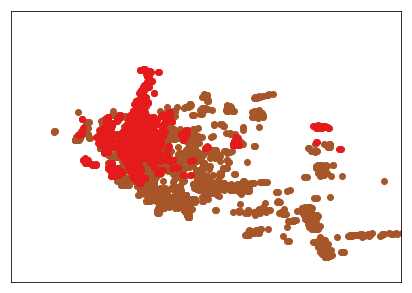

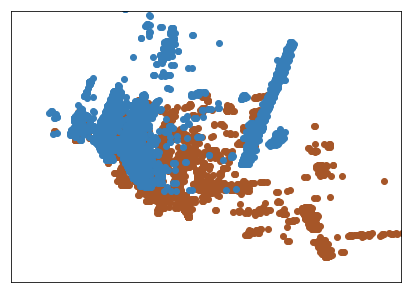

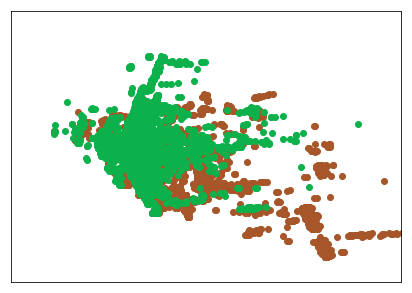

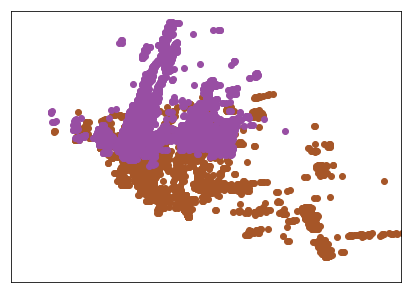

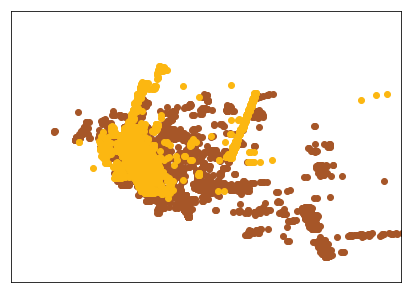

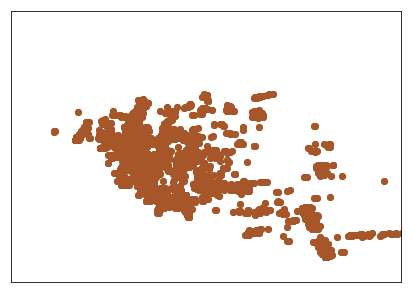

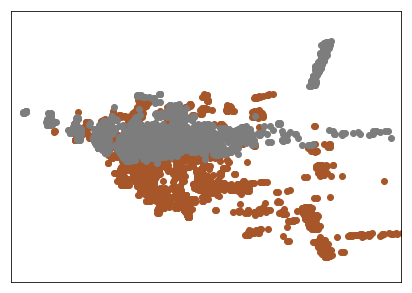

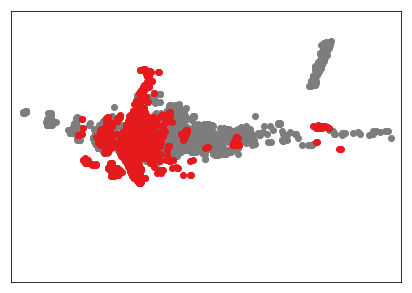

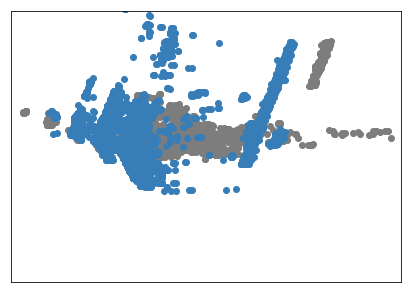

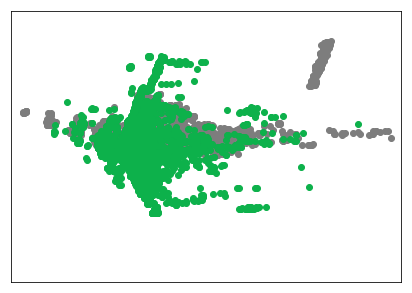

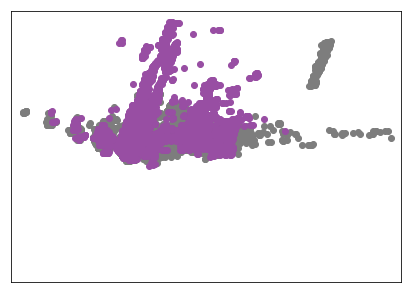

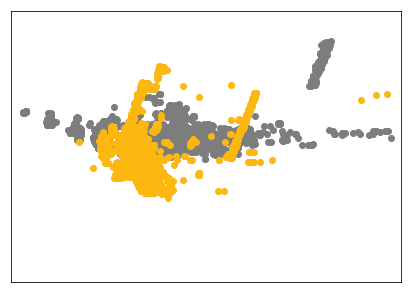

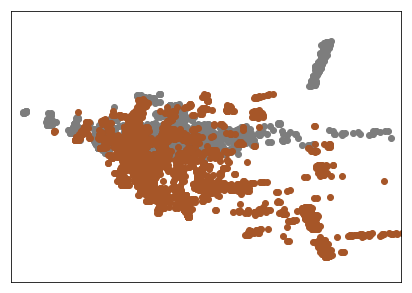

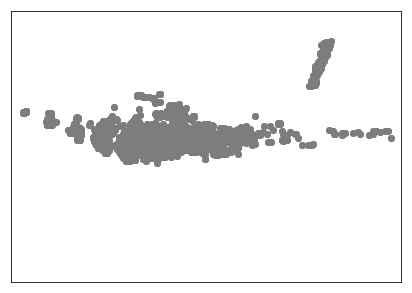

In [170]:
import matplotlib.pyplot as plt
import matplotlib


gradient = ['#e41a1c', '#377eb8','#0DB14B','#984ea3','#FCB711','#a65628','#7D7D7D']

for i,p in enumerate(part):
    temp1 = data_all[data_all['participant']==p]

    for i2,p2 in enumerate(part):
        temp2 = data_all[data_all['participant']==p2]
        
        plt.rcParams["figure.figsize"] = [7,5]
        fig = plt.figure()

        plt.scatter(temp1['pca1'], temp1['pca2'], c=gradient[i])
        plt.scatter(temp2['pca1'], temp2['pca2'], c=gradient[i2])

        axes = plt.gca()
        axes.set_xlim([-5,10])
        axes.set_ylim([-6,6])

        plt.xticks([])
        plt.yticks([])


        plt.show()

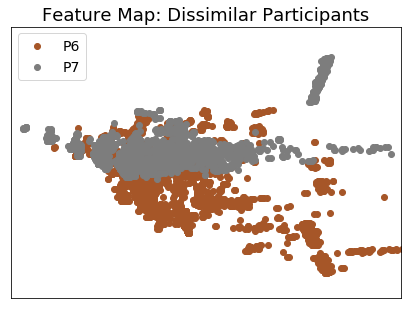

In [188]:
# Similar Participants

temp1 = data_all[data_all['participant']==17]

temp2 = data_all[data_all['participant']==18]

plt.rcParams["figure.figsize"] = [7,5]
fig, ax = plt.subplots()

plt.scatter(temp1['pca1'], temp1['pca2'], c=gradient[5], label='P6')
plt.scatter(temp2['pca1'], temp2['pca2'], c=gradient[6], label='P7')

ax.set_title('Feature Map: Dissimilar Participants', fontsize=18)

axes = plt.gca()
axes.set_xlim([-5,10])
axes.set_ylim([-6,6])

plt.xticks([])
plt.yticks([])
plt.legend(loc='upper left', fontsize=14)

plt.show()
fig.savefig('dissimilar_part.eps', format='eps', dpi=1000)

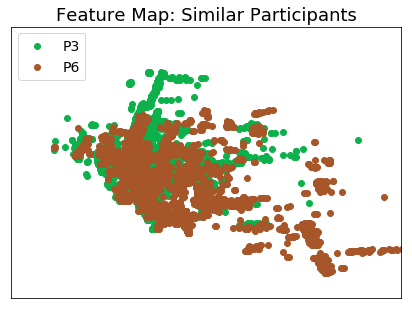

In [189]:
# Similar Participants

temp1 = data_all[data_all['participant']==9]

temp2 = data_all[data_all['participant']==17]

plt.rcParams["figure.figsize"] = [7,5]
fig, ax = plt.subplots()

plt.scatter(temp1['pca1'], temp1['pca2'], c=gradient[2], label='P3')
plt.scatter(temp2['pca1'], temp2['pca2'], c=gradient[5], label='P6')

ax.set_title('Feature Map: Similar Participants', fontsize=18)

axes = plt.gca()
axes.set_xlim([-5,10])
axes.set_ylim([-6,6])

plt.xticks([])
plt.yticks([])
plt.legend(loc='upper left', fontsize=14)

plt.show()
fig.savefig('similar_part.eps', format='eps', dpi=1000)

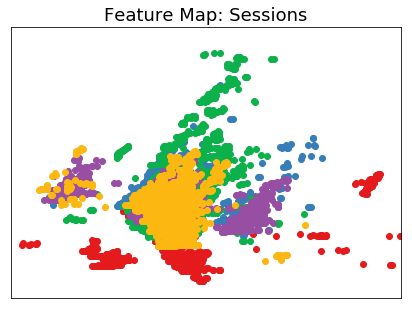

In [219]:
temp = data_all[data_all['participant']==5]

plt.rcParams["figure.figsize"] = [7,5]
fig, ax = plt.subplots()

ax.set_title('Feature Map: Sessions', fontsize=18)

axes = plt.gca()
axes.set_xlim([-2,2])
axes.set_ylim([-2,4])

sessions = temp['session_num'].unique()
sessions = sessions[:len(gradient)]
for i,s in enumerate(sessions):
    sess = temp[temp['session_num']==s]

    plt.scatter(sess['pca1'], sess['pca2'], c=gradient[i])

plt.xticks([])
plt.yticks([])

plt.show()
fig.savefig('sessions_map.eps', format='eps', dpi=1000)

In [155]:
from descartes import PolygonPatch

def plot_polygon(polygon):
    fig = pl.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    margin = .3

    x_min, y_min, x_max, y_max = polygon.bounds

    ax.set_xlim([x_min-margin, x_max+margin])
    ax.set_ylim([y_min-margin, y_max+margin])
    patch = PolygonPatch(polygon, fc='#999999', ec='#000000', fill=True, zorder=-1)
    ax.add_patch(patch)
    return fig

In [163]:
from shapely.ops import cascaded_union, polygonize
from scipy.spatial import Delaunay
import numpy as np
import math

def alpha_shape(points, alpha):
    """
    Compute the alpha shape (concave hull) of a set of points.

    @param points: Iterable container of points.
    @param alpha: alpha value to influence the gooeyness of the border. Smaller
                  numbers don't fall inward as much as larger numbers. Too large,
                  and you lose everything!
    """
    if len(points) < 4:
        # When you have a triangle, there is no sense in computing an alpha
        # shape.
        return geometry.MultiPoint(list(points)).convex_hull

    def add_edge(edges, edge_points, coords, i, j):
        """Add a line between the i-th and j-th points, if not in the list already"""
        if (i, j) in edges or (j, i) in edges:
            # already added
            return
        edges.add( (i, j) )
        edge_points.append(coords[ [i, j] ])

    #coords = np.array([point.coords[0] for point in points])
    coords = points
    tri = Delaunay(coords)
    edges = set()
    edge_points = []
    # loop over triangles:
    # ia, ib, ic = indices of corner points of the triangle
    for ia, ib, ic in tri.vertices:
        pa = coords[ia]
        pb = coords[ib]
        pc = coords[ic]

        # Lengths of sides of triangle
        a = math.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
        b = math.sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
        c = math.sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)

        # Semiperimeter of triangle
        s = (a + b + c)/2.0

        # Area of triangle by Heron's formula
        area = math.sqrt(s*(s-a)*(s-b)*(s-c))
        circum_r = a*b*c/(4.0*area)

        # Here's the radius filter.
        #print circum_r
        if circum_r < 1.0/alpha:
            add_edge(edges, edge_points, coords, ia, ib)
            add_edge(edges, edge_points, coords, ib, ic)
            add_edge(edges, edge_points, coords, ic, ia)

    m = geometry.MultiLineString(edge_points)
    triangles = list(polygonize(m))
    return cascaded_union(triangles), edge_points
